In [162]:
import numpy as np 
import pandas as pd 
import spacy 
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.parse.corenlp import CoreNLPParser 

from dotenv import load_dotenv
import os
import google.generativeai as genai 

import seaborn as sb 
import matplotlib.pyplot as plt 

import xml.etree.ElementTree as ET

In [46]:
df = pd.read_csv("Sentences.csv") 
print(df)

                                               sentence
0     The system shall refresh the display every 60 ...
1     The application shall match the color of the s...
2              If projected  the data must be readable.
3     On a 10x10 projection screen  90% of viewers m...
4      The product shall be available during normal ...
...                                                 ...
1285                                                â€‹
1286  Texts sent to that number will be sent to the ...
1287  If a question is not understood by our API, th...
1288  Upon the USB being plugged in the system shall...
1289  The system shall be able to handle 1000 custom...

[1290 rows x 1 columns]


In [136]:
class LingAnalyser: 
    MIN_SENT_LEN = 3 
    MAX_SENT_LEN = 40
    MIN_CLAUSE = 1
    MAX_CLAUSE = 3
    nlp = spacy.load("en_core_web_sm") 

    def analyseSent(self,txt): 
        words = nlp(txt)
        len_sent = len(words)
        len_clause =  sum(1 for word in words if word.dep_ in ("ROOT", "advcl", "ccomp", "xcomp", "relcl", "csubj")) 
        inconsistent_punct = self.check_punctuation_consistency(txt) 
        result={
            "isValid":True,
            "Complexity":"simple",
            "sent_len": len_sent, 
            "clause_count":len_clause,
            "SimplificationSuggested":False,
            "inconsistent_punct":inconsistent_punct
        }
        
        if(len_sent<self.MIN_SENT_LEN or len_clause<self.MIN_CLAUSE ): 
            result["isValid"]=False 
            return result
        
        if(len_clause>1 and len_clause<=self.MAX_CLAUSE): 
            result["Complexity"]="medium"
        if(len_sent>self.MAX_SENT_LEN or len_clause>self.MAX_CLAUSE) : 
            result["Complexity"]="complex"
            result["SimplificationSuggested"]=True
            
        return result

    def check_punctuation_consistency(self,txt):
        words = nlp(txt)
        issues = []
    
        # missing end punctuation
        for sent in words.sents:
            if sent.text.strip()[-1] not in ".?!":
                issues.append("Missing end punctuation.")
    
        # Multiple spaces
        if re.search(r'\s{2,}', txt):
            issues.append("Double or extra spaces.")
    
        # Space before punctuation
        if re.search(r'\s[,.?!]', txt):
            issues.append("Space before punctuation mark.")
    
        # Imbalanced quotes
        if txt.count('"') % 2 != 0:
            issues.append("Unbalanced double quotes.")
        if txt.count("'") % 2 != 0:
            issues.append("Unbalanced single quotes.")
    
        return issues

        
    def printDepTree(self,txt): 
        words = nlp(txt)
        spacy.displacy.render(words, style="dep", jupyter=True)
    def print_tree(self,token, level=0):
        print(" - -" * level + f"{token.text}({token.dep_})")
        for child in token.children:
            self.print_tree(child, level + 1) 
    def printParseTree(self,txt): 
        words = nlp(txt)
        for word in words:
            if word.dep_ == "ROOT":
                self.print_tree(word)
        
    def getSimplerVersion(self,txt):
        load_dotenv()  # loads .env automatically
        api_key = os.getenv("GEMINI_API_KEY")
        genai.configure(api_key=api_key)
        
        model = genai.GenerativeModel("gemini-2.5-flash")
        
        prompt = f"""You are a text simplification agent. Your job is to simplify text provided and return the simplified sentence.
        The provided text might contain multilple clauses. The simplified sentences shouldn't contain more than 3 clauses per sentence and
        the sentence lenght shouldn't be more than 40. You are allowed to split sentences to multiple sentences to achieve this.
        provide no other text with the response.
        Input_text:\"{txt}\""""
        
        response = model.generate_content(prompt)
        return response.text

In [ ]:
la = LingAnalyser() 
for s in df["sentence"][0:100]: 
    # print(s)
    # la.printDepTree(s)
    # la.printParseTree(s)
    # print(la.analyseSent(s)) 
    if(la.analyseSent(s)["SimplificationSuggested"]):
        print(s)
        print("Simplified: [",la.getSimplerVersion(s),"]")

In [163]:
raw_data = [] 
tree = ET.parse("./XMLZIPFile/0000 - cctns.xml")
root = tree.getroot() 
text = [elem.text.strip() for elem in root.iter() if elem.text and elem.text.strip()]
[raw_data.append(t) for t in text]
sentences = [] 
for c in raw_data:
    [sentences.append(s) for s in sent_tokenize(c)]
finalSrsDf = pd.DataFrame({"sentence":sentences}) 
finalSrsDf.to_csv("./srs.csv",index=False)

In [164]:
srs = pd.read_csv("srs.csv") 

In [165]:
la = LingAnalyser() 

sent_lens=[] 
clause_counts = []
isValid = [] 
complexities = [] 
inconsistent_punct = []

for s in srs["sentence"]: 
    inf = la.analyseSent(str(s))
    isValid.append(inf["isValid"])
    if(inf["isValid"]==False) : continue
    sent_lens.append(inf["sent_len"])
    clause_counts.append(inf["clause_count"]) 
    complexities.append(inf["Complexity"])
    [inconsistent_punct.append(inc) for inc in inf["inconsistent_punct"]]

# print(sent_lens)
# print(clause_counts)
# print(isValid)
# print(complexities)

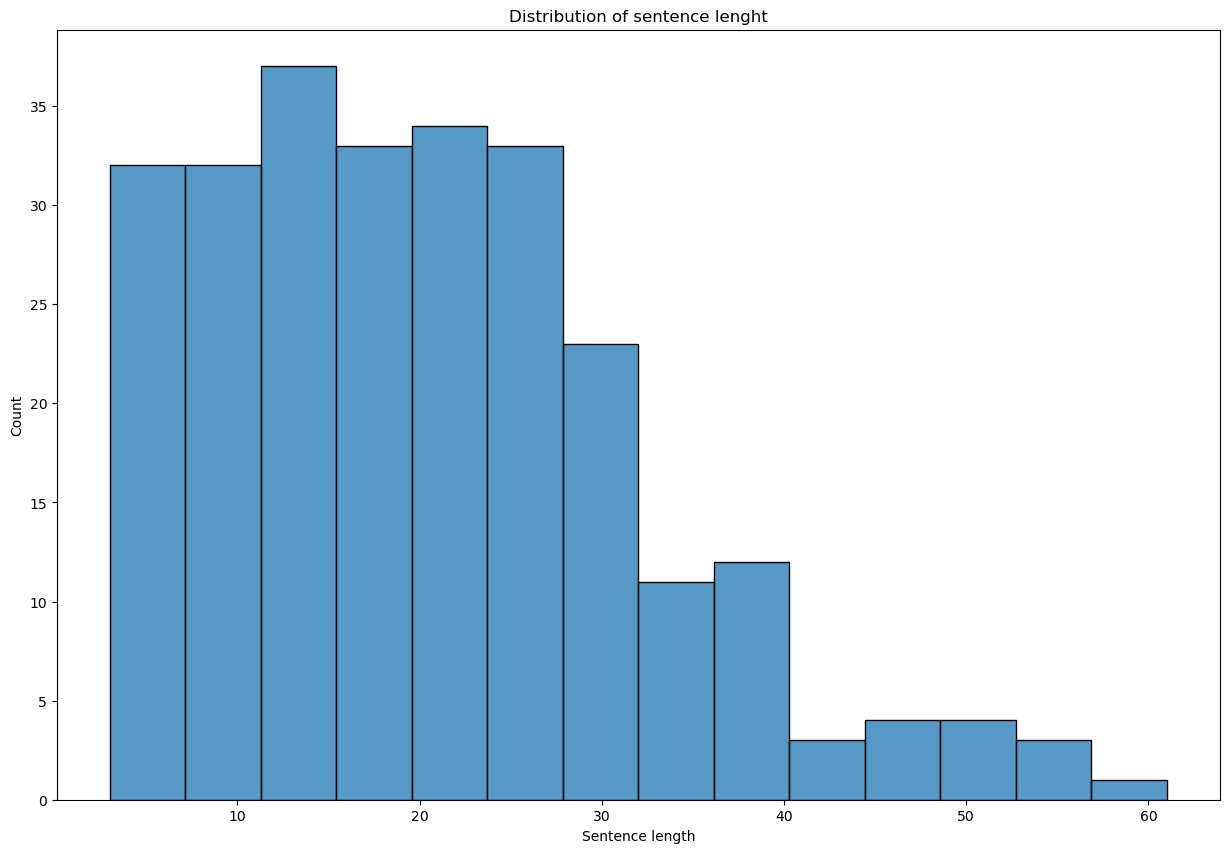

In [166]:
plt.figure(figsize=(15,10))
sb.histplot(sent_lens) 
plt.xlabel("Sentence length") 
plt.title("Distribution of sentence lenght") 
plt.show()

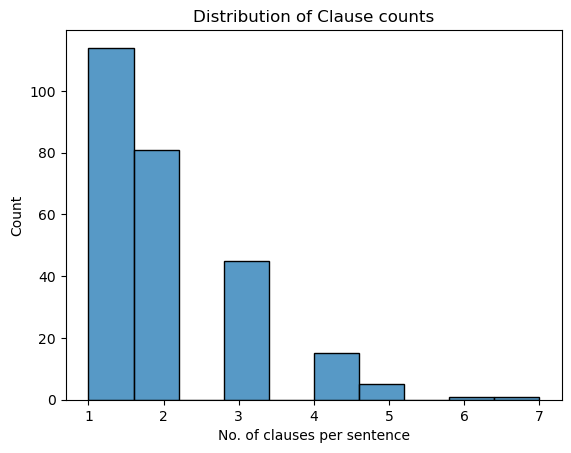

In [167]:
sb.histplot(clause_counts) 
plt.xlabel("No. of clauses per sentence") 
plt.title("Distribution of Clause counts")
plt.show()

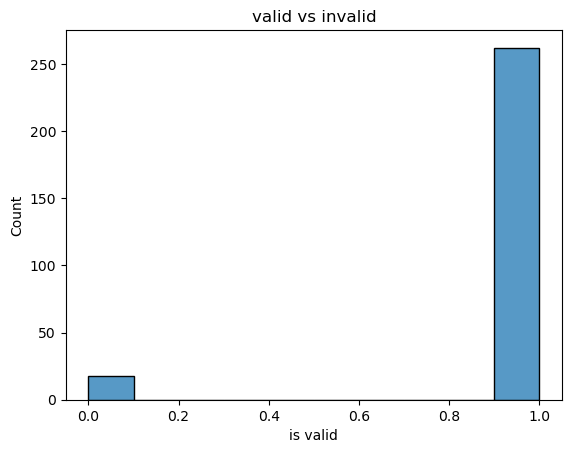

In [168]:
sb.histplot(isValid) 
plt.xlabel("is valid") 
plt.title("valid vs invalid")
plt.show()

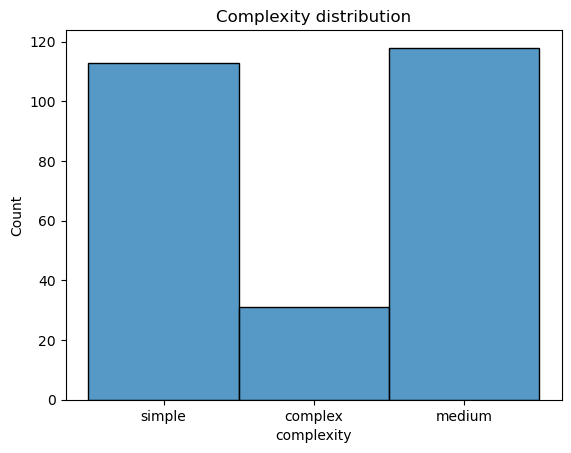

In [169]:
sb.histplot(complexities) 
plt.xlabel("complexity") 
plt.title("Complexity distribution")
plt.show()

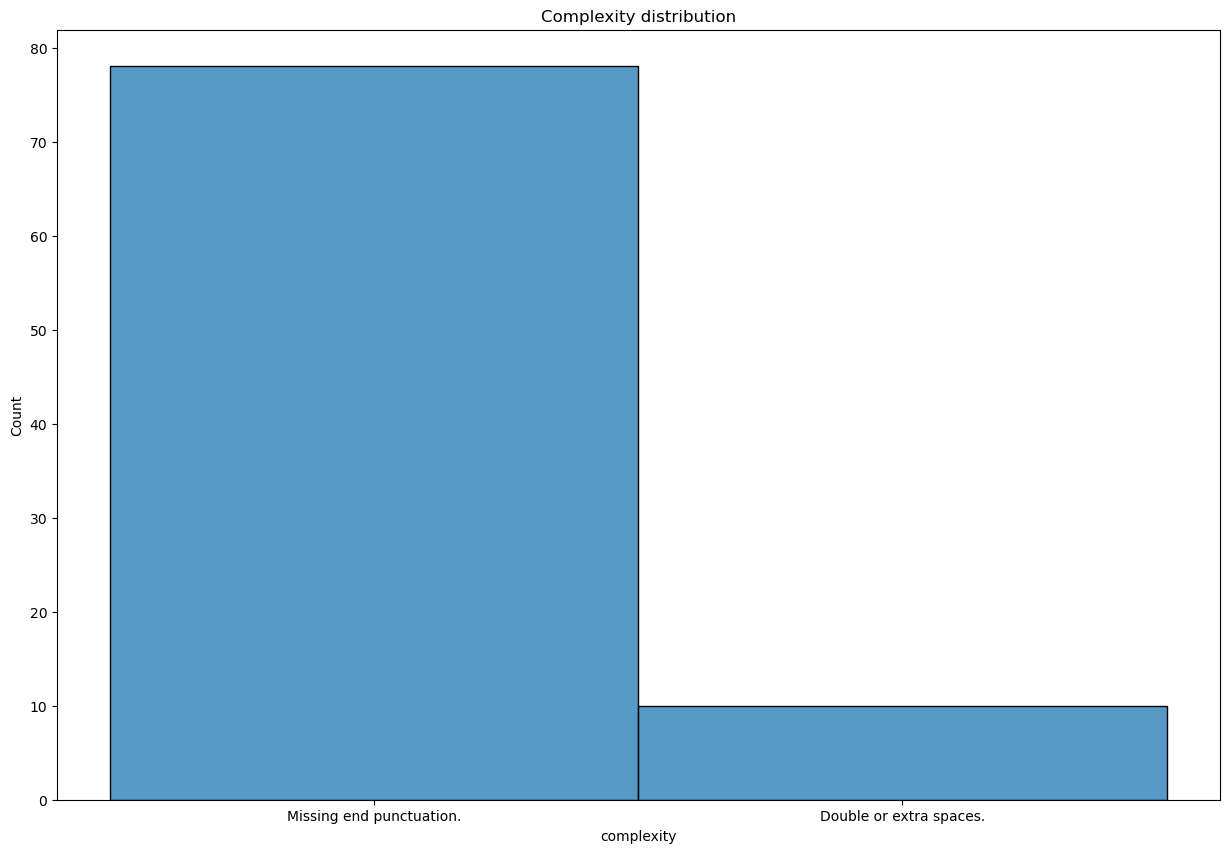

In [170]:
plt.figure(figsize=(15,10))
sb.histplot(inconsistent_punct) 
plt.xlabel("complexity") 
plt.title("Complexity distribution")
plt.show()